In [1]:
from dotenv import load_dotenv
import os
import matplotlib.pyplot as plt
from ohlc_data_process import calculate_dmi_rsi_mfi, fetch_data

load_dotenv()

openai_api_key = os.getenv('T_OPENAI_API_KEY')
os.environ['OPENAI_API_KEY'] = openai_api_key


In [2]:
from langchain import OpenAI

openai = OpenAI(
    #model_name='text-davinci-003',
    model_name='text-ada-001',
    temperature=0.7
)

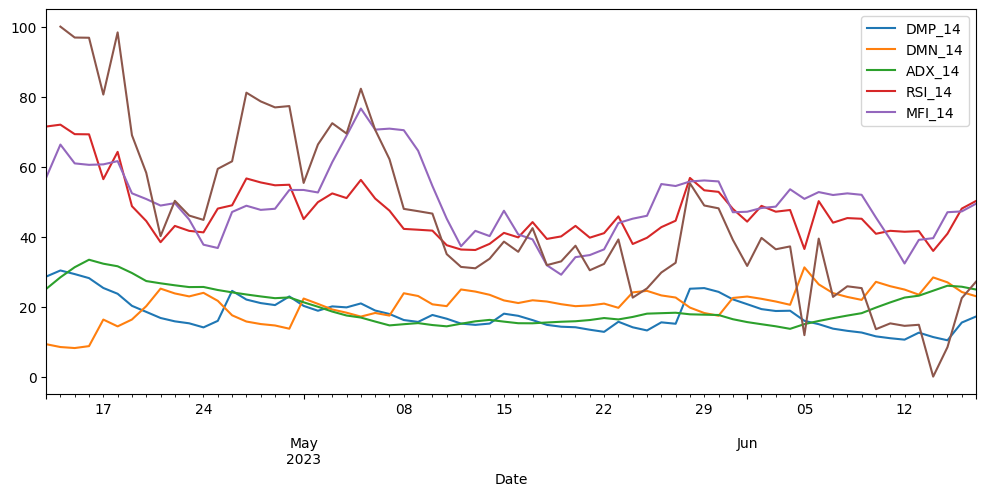

In [3]:
df = fetch_data('BTC-USD', '3mo', '1d')
indicator_data = calculate_dmi_rsi_mfi(df)
normalized_close = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min()) * 100
indicator_data.plot(y=["DMP_14", "DMN_14", "ADX_14", "RSI_14", "MFI_14"], figsize=(12,5))
normalized_close.iloc[28:].plot(label='norm_close')
plt.show()

In [4]:
from langchain import FewShotPromptTemplate, PromptTemplate

# create our examples
examples = [
    {
        "query": f"RSI indicator value is 70.34, MFI indicator value is 59.02, DMP indicator value is 31.3,"
                 f" DMN indicator value is 12.77 and ADX indicator value is 41.26."
                 f" What is your advice for trading for those indicator values?",
        "answer": "The RSI indicator value being above 70 at this moment indicates an overbought zone has been entered."
                  "The MFI value trending above the average confirms the flow of money. On the DMi side, "
                  "the DMP (positive directional movement indicator) value is above "
                  "the DMN (negative directional movement indicator) value, "
                  "and ADX is strongly trending above 25 and at 40 levels, "
                  "indicating a strong bull trend that has entered in a short period of time. "
                  "When considering the flow of money and the overbought zone, it may be advisable "
                  "to take some profits and waiting next market movements."
    }, {
        "query": f"RSI indicator value is 40.14, MFI indicator value is 41, DMP indicator value is 21.01,"
                 f" DMN indicator value is 23.67 and ADX indicator value is 20.76."
                 f" What is your advice for trading for those indicator values?",
        "answer": "The RSI indicator value dropping around 40 indicates approaching the selling zone. "
                  "The MFI index also dropping around 40 supports this. Although ADX suggests that there is no strong trend below 25, "
                  "it can be observed that DMN is above DMP, creating selling pressure. "
                  "My recommendation would be to wait for a better buying opportunity at this point."
    }
]

# create a example template
example_template = """
User: {query}
AI: {answer}
"""

# create a prompt example from above template
example_prompt = PromptTemplate(
    input_variables=["query", "answer"],
    template=example_template
)

# now break our previous prompt into a prefix and suffix
# the prefix is our instructions
prefix = """Answer the question based on the context below.
You are the trading advisor. Also you are expert on RSI, MFI and DMP, DMI indicators.

Context: RSI indicator value range betwwen 0-100. RSI value 70 and above meaning that overbought area.
 So you should sell your coin. also value 80 is a extreme overbought and you act cautiously.
 RSI value 30 that meaning is overselling area. and value 20 is extreme overselling are.
 if the RSI value are 20-30s you should bought this coin. 30-70 range waiting or
 you can look other indicator results.
 MFI indicator value range betwen 0-100. MFI value 80 and above meaning that overbought area.
 So you should sell your coin. also value 90 is a extreme overbought and you should act cautiously.
 MFI value 20 that meaning is overselling area. and value 10 is extreme overselling are.
 if the MFI value are 10-20s you should bought this coin. 20-80 range waiting or
 you can look other indicator results.
 Else it shows overselling condition between 0-25.
 DMI indicator is a collection of indicators including DMP, DMI, and ADX. The Plus Direction Indicator DMP and
 Minus Direction Indicator DMI show the current price direction. When the DMP is above DMN,
 the current price momentum is up. When the DMN is above DMP, the current price momentum is down.
 ADX measures the strength of the trend, either up or down; a reading above 25 indicates a strong trend.
Here are some examples:
"""
# and the suffix our user input and output indicator
suffix = """
User: {query}
AI: """

# now create the few shot prompt template
few_shot_prompt_template = FewShotPromptTemplate(
    examples=examples,
    example_prompt=example_prompt,
    prefix=prefix,
    suffix=suffix,
    input_variables=["query"],
    example_separator="\n\n"
)

In [5]:
# df = fetch_data('BTC-USD', '3mo', '1d')
# indicator_data = calculate_dmi_rsi_mfi(df)
rsi_14 = indicator_data.RSI_14.iloc[-1]
mfi_14 = indicator_data.MFI_14.iloc[-1]
dmp_14 = indicator_data.DMP_14.iloc[-1]
dmn_14 = indicator_data.DMN_14.iloc[-1]
adx_14 = indicator_data.ADX_14.iloc[-1]

query = f"RSI indicator value is {rsi_14:.2f}, MFI indicator value is {mfi_14:.2f}, DMP indicator value is {dmp_14:.2f}," \
        f" DMN indicator value is {dmn_14:.2f} and ADX indicator value is {adx_14:.2f}." \
        f" What is your advice for trading for those indicator values?"

print(openai(
    few_shot_prompt_template.format(
        query= query
    )
))



The RSI indicator value between 50.19 and 50.42 indicates an overprice area has been entered. The MFI indicator value between 49.42 and 49.98 is supportive because it means that there is still money to be made. The DMP indicator value between 17.18 and 17.77 is strong indication that the flow of money is slowing down. Although ADX is strong at 24.88, it can be seen that the DMN (positive directional movement indicator) is above DMP (negative directional movement indicator) value. This means that there is still more money to be made still.
